In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Define domain, BC

xmin_org, xmax_org = 0, 10000
ymin_org, ymax_org = 0 , 10000

delta_x = xmax_org - xmin_org
delta_y = ymax_org - ymin_org

xmin = xmin_org/delta_x
xmax = xmax_org/delta_x
ymin = ymin_org/delta_y
ymax = ymax_org/delta_y

# Define the boundary conditions
h1 = 60            # at x = 0 for all y_b1, Dirichlet boundary at the left (m)
h2 = 0             # at x = 1 for all y, Dirichlet boundary at the right (m)
dh_dy1 = 0           # at y = 0 for all x, Neumann boundary at the bottom (m)
dh_dy2 = 0           # at y = 1 for all x, Neumann boundary at the top (m)

# define the number of points on each boundary and
N_b = 100          # Number of boundary condition points on each side.
N_r = 5000        # Number of collocation points within the domain

In [ ]:
# Generate BC and collocation points

def generate_BCs_and_colloc(key, N_b, N_r, ymin, ymax, xmin, xmax, h1, h2, dh_dy1, dh_dy2):
    bk1, bk2, bk3, bk4, r1k, r2k = jax.random.split(key, 6)
    y_b1 = jax.random.uniform(bk1, minval=ymin, maxval=ymax, shape=(N_b, 1))
    x_b1 = jnp.zeros_like(y_b1) * xmin
    bc_1 = jnp.ones_like(y_b1) * h1
    BC_1 = jnp.concatenate([x_b1, y_b1, bc_1], axis=1)
    y_b2 = jax.random.uniform(bk2, minval=ymin, maxval=ymax, shape=(N_b, 1))
    x_b2 = jnp.ones_like(y_b2) * xmax
    bc_2 = jnp.ones_like(y_b2) * h2
    BC_2 = jnp.concatenate([x_b2, y_b2, bc_2], axis=1)
    x_b3 = jax.random.uniform(bk3, minval=xmin, maxval=xmax, shape=(N_b, 1))
    y_b3 = jnp.zeros_like(x_b3) * ymin
    bc_3 = jnp.ones_like(x_b3) * dh_dy1
    BC_3 = jnp.concatenate([x_b3, y_b3, bc_3], axis=1)
    x_b4 = jax.random.uniform(bk4, minval=xmin, maxval=xmax, shape=(N_b, 1))
    y_b4 = jnp.ones_like(x_b4) * ymax
    bc_4 = jnp.ones_like(x_b4) * dh_dy2
    BC_4 = jnp.concatenate([x_b4, y_b4, bc_4], axis=1)
    conds = [BC_1, BC_2, BC_3, BC_4]
    y_c = jax.random.uniform(r1k, minval=ymin, maxval=ymax, shape=(N_r, 1))
    x_c = jax.random.uniform(r2k, minval=xmin, maxval=xmax, shape=(N_r, 1))
    colloc = jnp.concatenate([x_c, y_c], axis=1)
    return x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c, conds, colloc

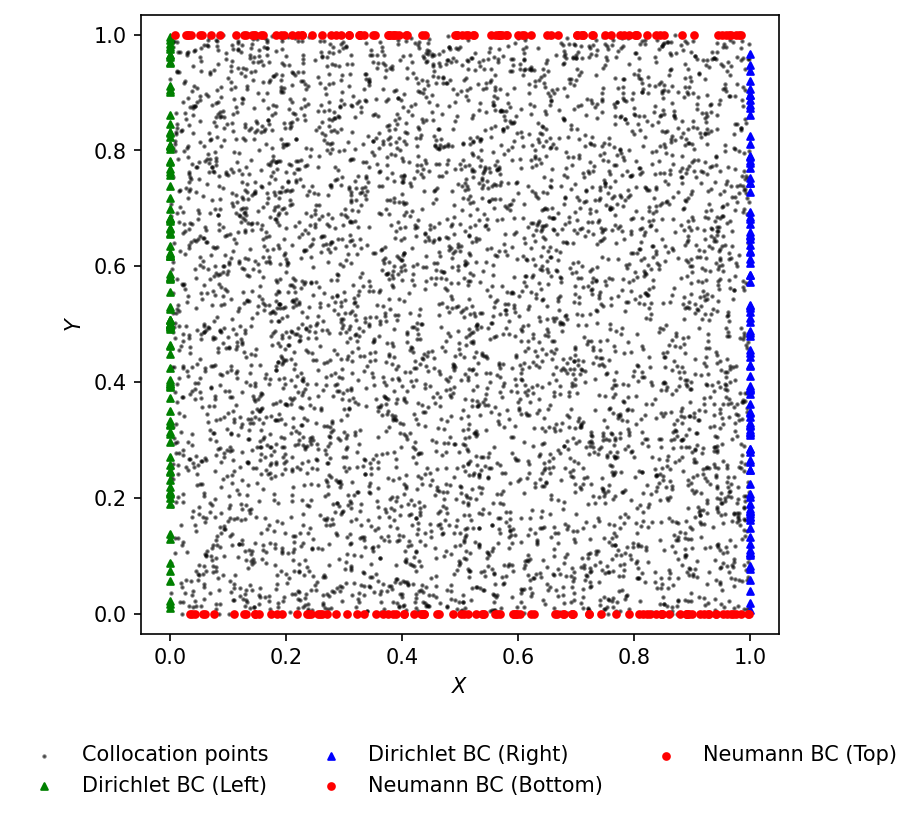

In [ ]:
# Visulaize boundary and collocation points

def plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c):

    plt.figure(figsize=(5, 5.5), dpi=150)

    # Plot each set of boundary conditions
    s = 5
    plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.5, label='Collocation points', s=s)
    s = 10
    plt.scatter(x_b1, y_b1, c='green', marker='^', label='Dirichlet BC (Left)', s=s)
    plt.scatter(x_b2, y_b2, c='blue', marker='^', label='Dirichlet BC (Right)', s=s)
    plt.scatter(x_b3, y_b3, c='red', marker='o', label='Neumann BC (Bottom)', s=s)
    plt.scatter(x_b4, y_b4, c='red', marker='o', label='Neumann BC (Top)', s=s)

    # Plot collocation points
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.axis('equal')
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.95)
    plt.show()

# Parameter definition
N_b, N_r = 100, 5000
ymin, ymax = 0.0, 1.0
xmin, xmax = 0.0, 1.0
h1, h2 = 60, 0.0
dh_dy1, dh_dy2 = 0.0, 0.0
key = jax.random.PRNGKey(42)

# Generate data
x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c, conds, colloc = generate_BCs_and_colloc(key, N_b, N_r, ymin, ymax, xmin, xmax, h1, h2, dh_dy1, dh_dy2)

plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c)

In [ ]:
def hydraulic_conductivity(x, y):
  T_x = jnp.ones_like(x)*1.5
  T_y = jnp.ones_like(y)*1.5
  return T_x, T_y

In [ ]:
# PDE residual for 2-D darcy equation

def pde_residual_2d_darcy(x,y,h):
    """
    Compute the PDE residual for the 2D Laplace equation.

    Inputs:
    x, y: Coordinates of collocation points (N x 1).
    h: Lambda function representing the neural network solution h(x, y).

    Output:
    Residual of the PDE at the collocation points (N x 1).
    """
    T_x, T_y = hydraulic_conductivity(x, y)

    h_x = lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),0)(x,y)
    h_xx = lambda x,y:jax.grad(lambda x,y:jnp.sum(h_x(x,y)),0)(x,y)

    h_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),1)(x,y)
    h_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(h_y(x,y)),1)(x,y)


    return T_x*h_xx(x,y) + T_y*h_yy(x,y)

In [ ]:
# Define Neural Network Architecture
def neural_net(params, x, y):
    """
    Forward pass of a neural network to predict h(x, y).

    Inputs:
    params: Neural network parameters (list of weights and biases).
    x, y: Input coordinates (N x 1).

    Output:
    Predicted h(x, y) values (N x 1).
    """
    X = jnp.concatenate([x, y],axis=1)
    *hidden,last = params
    for layer in hidden :
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    return X@last['W'] + last['B']


# Function to initialize parameters of the neural network (weights and biases)
def init_params(layers):
    """
    Initialize parameters (weights and biases) for a neural network with specified layers.

    Args:
        layers: List of integers representing the number of nodes in each layer.
                For example, [2, 20, 20, 1] creates a network with input layer (2 nodes),
                two hidden layers (20 nodes each), and an output layer (1 node).

    Returns:
        params: List of dictionaries containing 'W' (weights) and 'B' (biases) for each layer.
    """
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)  # Generate random keys for each layer
    params = list()  # Initialize a list to store layer parameters

    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):  # Loop through layer dimensions
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))  # Xavier initialization bounds
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))  # Initialize weights
        B = jax.random.uniform(key, shape=(n_out,))  # Initialize biases
        params.append({'W': W, 'B': B})  # Append layer parameters (weights and biases) to the list

    return params  # Return the initialized parameters

In [ ]:
# Define loss function

@jax.jit
def loss_fun(params, colloc, conds):
    """
    Calculate the total loss for the PINN.

    Inputs:
        params: Neural network parameters (list of weights and biases).
        colloc: Collocation points for the PDE residual (N x 2).
        conds: Boundary condition data (list of 4 elements, one for each BC).

    Output:
        Scalar total loss value.
    """
    x_c, y_c = colloc[:, [0]], colloc[:, [1]]

    h_nn = lambda x, y: neural_net(params, x, y)

    pde_loss = jnp.mean((pde_residual_2d_darcy(x_c, y_c, h_nn))**2)

    # Loss at the left and right Dirichlet BCs
    dbc_loss = 0
    for cond in conds[0:2]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        #dbc_loss += MSE(P_nn(x_b, y_b), u_b)  # Dirichlet BC loss
        dbc_loss += jnp.mean((h_nn(x_b, y_b) - u_b)**2 ) # Dirichlet BC loss

    # Loss at the bottom and top Neumann BCs
    nbc_loss = 0
    h_nn_y = lambda x, y: jax.grad(lambda x, y: jnp.sum(h_nn(x, y)), 1)(x, y)  # Neumann BCs derivative
    for cond in conds[2:4]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        #nbc_loss += MSE(h_nn_y(x_b, y_b), u_b)  # Neumann BC loss
        nbc_loss += jnp.mean((h_nn_y(x_b, y_b) - u_b)**2)  # Neumann BC loss

    # Total loss (summed components)
    loss = pde_loss + dbc_loss + nbc_loss

    return loss

In [ ]:
# PINN prediction and plotting results
nx = 31
x = np.linspace(xmin, xmax, nx)
dx = x[1] - x[0]
ny = 31
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

In [ ]:
# Define hyperparameters for the neural network and training
hidden_nodes = 20      # Number of nodes in each hidden layer
hidden_layers = 3      # Number of hidden layers in the neural network
lr = 1e-3              # Learning rate for the optimizer
epochs = 10000          # Number of epochs for training


# Construct the MLP (Multilayer Perceptron) using the specified architecture

params = init_params([2] + [20,20,20] * hidden_layers + [1])

# The network has 2 input nodes, `hidden_layers` layers with `hidden_nodes`, and 1 output node.

# Define the optimizer (Adam optimizer with the specified learning rate)
optimizer = optax.adam(lr)

# Initialize the optimizer state using the network parameters
opt_state = optimizer.init(params)

# Parameters update function
@jax.jit
def update(opt_state,params,colloc,conds):
    """
    Perform a single optimization step:
    - Calculate gradients of the loss with respect to network parameters.
    - Update the parameters using the optimizer.

    Inputs:
    opt_state: Current optimizer state.
    params: Current neural network parameters (weights and biases).
    colloc: Collocation points for the PDE residual loss.
    conds: Boundary condition data for Dirichlet and Neumann conditions.

    Outputs:
    opt_state: Updated optimizer state.
    params: Updated network parameters.
    """
    # Get the gradient w.r.t to MLP params
    grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

    #Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params


#%% PINN training loop
print('PINN training started...')

# Initialize tracking variables
best_params = params
best_loss = float('inf')
best_epoch = 0

# Initialize lists to track all losses and epochs
all_losses = []
all_epochs = []

# Training loop
for epoch in range(epochs+1):
    # Update the optimizer state and parameters
    opt_state, params = update(opt_state, params, colloc, conds)

    # Calculate the current loss
    current_loss = loss_fun(params, colloc, conds)

    # Store loss and epoch
    all_losses.append(current_loss)
    all_epochs.append(epoch)

    # Update the best parameters if the current loss is the lowest
    if current_loss < best_loss:
        best_loss = current_loss
        best_params = params
        best_epoch = epoch

    # Print loss and epoch info
    if epoch % 100 == 0:
        print(f'Epoch={epoch}\tloss={current_loss:.3e}')
        pinn_h = (neural_net(best_params, X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1))).reshape(nx,ny)


print('PINN training done!')
print(f'Best Epoch = {best_epoch}\tBest Loss = {best_loss:.3e}')

PINN training started...
Epoch=0	loss=3.566e+03
Epoch=100	loss=3.106e+03
Epoch=200	loss=2.857e+03
Epoch=300	loss=2.668e+03
Epoch=400	loss=2.512e+03
Epoch=500	loss=2.380e+03
Epoch=600	loss=2.269e+03
Epoch=700	loss=2.176e+03
Epoch=800	loss=2.098e+03
Epoch=900	loss=2.034e+03
Epoch=1000	loss=1.981e+03
Epoch=1100	loss=1.938e+03
Epoch=1200	loss=1.904e+03
Epoch=1300	loss=1.877e+03
Epoch=1400	loss=1.856e+03
Epoch=1500	loss=1.840e+03
Epoch=1600	loss=1.828e+03
Epoch=1700	loss=1.819e+03
Epoch=1800	loss=1.813e+03
Epoch=1900	loss=1.808e+03
Epoch=2000	loss=1.805e+03
Epoch=2100	loss=1.803e+03
Epoch=2200	loss=1.802e+03
Epoch=2300	loss=1.801e+03
Epoch=2400	loss=1.801e+03
Epoch=2500	loss=1.800e+03
Epoch=2600	loss=1.800e+03
Epoch=2700	loss=1.800e+03
Epoch=2800	loss=1.800e+03
Epoch=2900	loss=1.800e+03
Epoch=3000	loss=1.800e+03
Epoch=3100	loss=1.800e+03
Epoch=3200	loss=1.800e+03
Epoch=3300	loss=1.800e+03
Epoch=3400	loss=1.800e+03
Epoch=3500	loss=1.800e+03
Epoch=3600	loss=1.800e+03
Epoch=3700	loss=1.800e+03

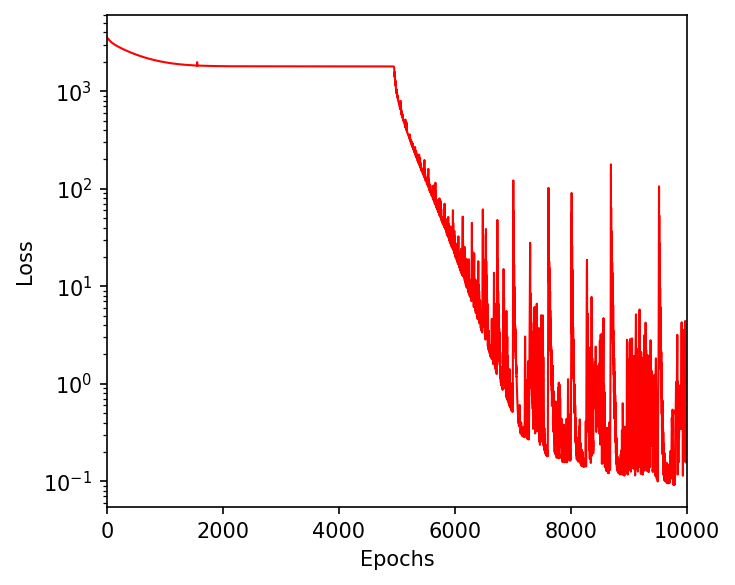

In [ ]:
# Plotting for PINN losses during training
def plot_pinn_training(all_losses, all_epochs):
    plt.figure(figsize = (5, 4), dpi = 150)
    plt.semilogy(all_epochs, all_losses, '-r', markersize = 4, linewidth = 1.0)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.legend(prop={"size": fontsize_legend}, loc="best")
    plt.xlim(min(all_epochs), max(all_epochs))
    plt.tight_layout()

plot_pinn_training(all_losses, all_epochs)

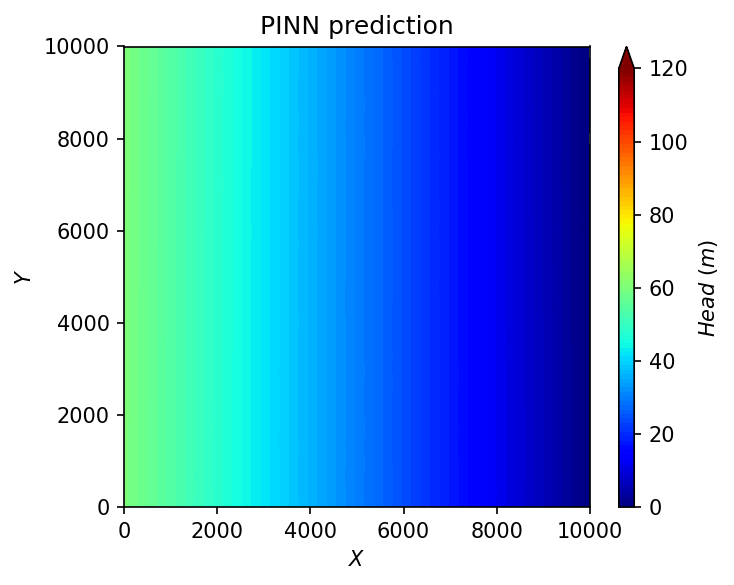

In [ ]:
# Plotting 2D head distribution

def plot_2d_pressure_distribution(X_scaled, Y_scaled, h_scaled, title, cbar_label):
    # Restore physical coordinates
    X_phys = X_scaled * delta_x + xmin_org
    Y_phys = Y_scaled * delta_y + ymin_org

    plt.figure(figsize=(5, 4), dpi=150)
    cmap = 'jet'
    levels = np.linspace(0, 120, 100)
    contour = plt.contourf(X_phys, Y_phys, h_scaled, levels=levels, cmap=cmap, extend='max')
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    cbar = plt.colorbar(contour, aspect=30)
    cbar.set_label(cbar_label)
    cbar.set_ticks(np.arange(0, 121, 20))
    plt.xlim(np.min(X_phys), np.max(X_phys))
    plt.ylim(np.min(Y_phys), np.max(Y_phys))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Use physical coordinates in plotting
title = "PINN prediction"
cbar_label = "$Head\\ (m)$"
plot_2d_pressure_distribution(X, Y, pinn_h, title, cbar_label)

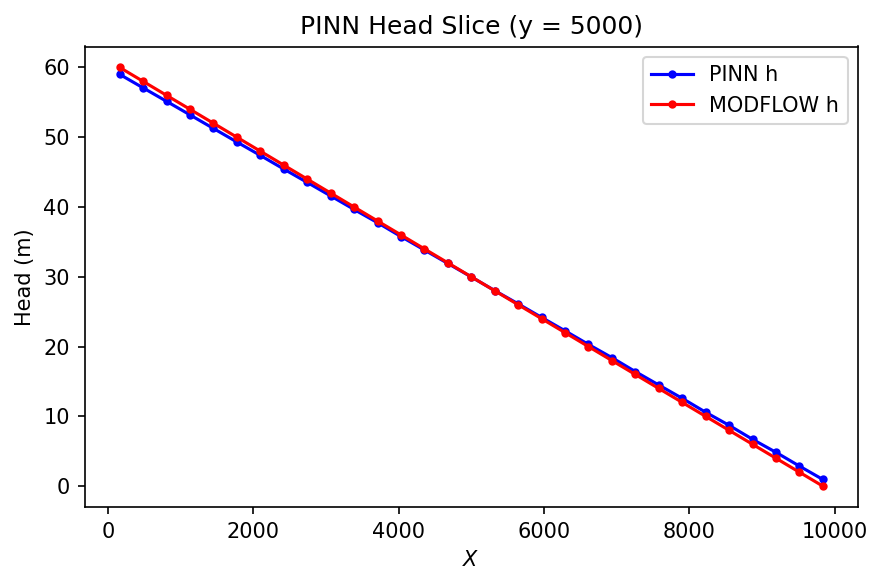

In [ ]:
# Plot head slice at y = 5000 m

def plot_head_slice_with_extra(X_phys, Y_phys, h, y0_phys, title, xlabel, ylabel, extra_h_vals):
    """
    - X_phys, Y_phys: 2D meshgrid (physical coordinates)
    - h: 2D array of head values (same shape as X_phys / Y_phys)
    - y0_phys: y = 5000
    - extra_h_vals: Additional head values at y = y0_phys,
                    corresponding to each x location (1D array)
    """
    # 1) Find the row index closest to y0_phys
    y_column = Y_phys[:, 0]                      # y-coordinate values of each row (first column)
    idx = np.argmin(np.abs(y_column - y0_phys))  # Index closest to y0_phys

    # 2) x_line (x-coordinates of the selected row),
    #    h_line (existing PINN-predicted head values)
    x_line = X_phys[idx, :]      # shape: [N,]
    h_line = h[idx, :]           # shape: [N,]

    # 3) Check whether extra_h_vals has the same length as x_line
    extra_h_vals = np.array(extra_h_vals, dtype=float)
    if extra_h_vals.shape[0] != x_line.shape[0]:
        raise ValueError(
            f"Length of extra_h_vals ({extra_h_vals.shape[0]}) "
            f"does not match length of x_line ({x_line.shape[0]})."
        )

    # 4) Plot
    plt.figure(figsize=(6, 4), dpi=150)

    # 4-1) Existing PINN-predicted head
    #      (blue line with circular markers)
    plt.plot(x_line, h_line, '-o', color='b', markersize=3, label='PINN h')

    # 4-2) Additional head values
    #      (red line with circular markers)
    plt.plot(x_line, extra_h_vals, '-o', color='r', markersize=3, label='MODFLOW h')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (y = {y0_phys})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage

X_phys = X * delta_x + xmin_org
Y_phys = Y * delta_y + ymin_org
y0_phys = 5000
title_slice = "PINN Head Slice"
xlabel = "$X$"
ylabel = "Head (m)"

# 2) MODFLOW-provided additional head values
#    (corresponding to each x location along the slice)
extra_h_vals = [
    60,
    57.99965,
    55.99953,
    53.99976,
    51.99983,
    49.99985,
    47.99987,
    45.99985,
    43.99979,
    41.99972,
    39.99969,
    37.99969,
    35.99972,
    33.99977,
    31.99981,
    29.99981,
    27.99977,
    25.99968,
    23.99955,
    21.99942,
    19.99931,
    17.99925,
    15.99924,
    13.99929,
    11.99937,
    9.999427,
    7.999483,
    5.999515,
    3.999377,
    1.998851,
    0
]

# 3) Call the function
plot_head_slice_with_extra(
    X_phys, Y_phys, pinn_h, y0_phys,
    title_slice, xlabel, ylabel,
    extra_h_vals
)

PINN prediction updated on MODFLOW-aligned grid.


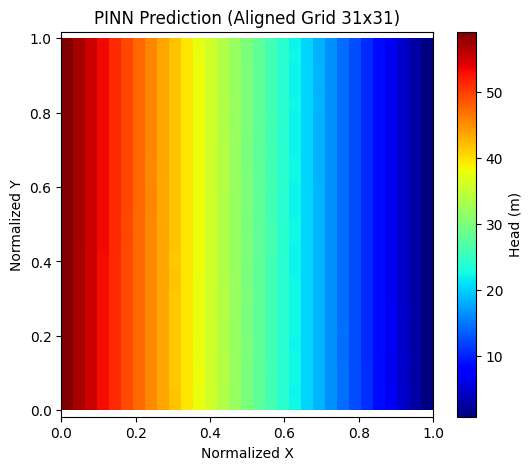

In [ ]:
# Check results at same locations with MODFLOW grid

nx = 31
ny = 31

# Compute cell size in the normalized coordinate system (0–1)
# (Assuming the PINN was trained in the range 0–1: xmin = 0, xmax = 1)
Lx_norm = xmax - xmin
Ly_norm = ymax - ymin

dx_norm = Lx_norm / nx
dy_norm = Ly_norm / ny

# [Key modification] Generate coordinates based on cell centers
# Instead of using linspace from boundary to boundary,
# the coordinates should start from 'start + dx/2' and end at 'end − dx/2'
# to represent cell centers.
x = np.linspace(xmin + dx_norm/2, xmax - dx_norm/2, nx)
y = np.linspace(ymin + dy_norm/2, ymax - dy_norm/2, ny)

# Generate the grid
X, Y = np.meshgrid(x, y)
X_flat = X.flatten().reshape(-1, 1)
Y_flat = Y.flatten().reshape(-1, 1)

# PINN prediction (on the modified grid)
# 'best_params' must be from a trained model.
if 'best_params' in locals():
    pinn_h_flat = neural_net(best_params, X_flat, Y_flat)
    pinn_h = pinn_h_flat.reshape(ny, nx)
    print("PINN prediction updated on MODFLOW-aligned grid.")
else:
    print("Note: 'best_params' not found. Run training first.")

# Visual Inspection
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, pinn_h, shading='auto', cmap='jet')
plt.colorbar(label='Head (m)')
plt.title(f'PINN Prediction (Aligned Grid {nx}x{ny})')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.axis('equal')
plt.show()

In [ ]:
# 30% random sampling and RMSE calculation

base_path = os.getcwd()
data_folder = os.path.join(base_path, 'data')
file_name = 'Case1.txt'
file_path = os.path.join(data_folder, file_name)

# 1. Check file existence and load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Can not find data file: {file_path}")

try:
    # 2. Load data
    df = pd.read_csv(file_name, skipinitialspace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    # 3. Improved active-cell filtering logic
    if 'Active' in df.columns:
        print("'Active' column found. Filtering active cells...")
        df_active = df[df['Active'] == 1].copy()
    else:
        print("'Active' column NOT found. Assuming all rows are valid.")
        # Optional: filter potential outliers (e.g., dry cells: 1E30, etc.)
        # Head values are generally within -100 ~ 10000, so values outside this range are excluded
        df_active = df[(df['f'] > -1000) & (df['f'] < 10000)].copy()
        print(f"Filtered valid head range (-1000 ~ 10000). Rows: {len(df)} -> {len(df_active)}")

    # 4. Infer grid information
    Nx_mf = df['j'].max()
    Ny_mf = df['i'].max()

    # Physical domain size
    L_x = 10000.0
    L_y = 10000.0

    # Compute cell size
    dx_phys = L_x / Nx_mf
    dy_phys = L_y / Ny_mf

    # Coordinate transformation (MODFLOW index -> physical coordinates)
    df_active['x_phys'] = (df_active['j'] - 0.5) * dx_phys
    df_active['y_phys'] = L_y - (df_active['i'] - 0.5) * dy_phys

    # Normalize inputs for PINN
    df_active['x_norm'] = df_active['x_phys'] / L_x
    df_active['y_norm'] = df_active['y_phys'] / L_y

    # PINN prediction
    x_in = df_active['x_norm'].values.reshape(-1, 1)
    y_in = df_active['y_norm'].values.reshape(-1, 1)
    x_jax = jnp.array(x_in)
    y_jax = jnp.array(y_in)

    if 'best_params' not in locals():
        raise NameError("best_params is undefined. Train the model first.")

    h_pinn = neural_net(best_params, x_jax, y_jax)
    h_mf = df_active['f'].values.reshape(-1, 1)
    N_total = len(h_mf)

    # Compute 30% sample size
    sample_ratio = 0.30
    n_samples = int(N_total * sample_ratio)

    print(f"\n--- Random Sampling ({sample_ratio*100}%) ---")
    print(f"Total Points: {N_total}")
    print(f"Selected Points: {n_samples}")

    # 3. Generate random indices (without replacement)
    # (Seed fixed to 42 for reproducibility. Remove seed for different results each run.)
    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(N_total, size=n_samples, replace=False)

    # Extract sampled data
    h_pinn_sampled = h_pinn[random_indices]
    h_mf_sampled = h_mf[random_indices]

    # Compute RMSE
    diff = h_pinn_sampled - h_mf_sampled
    rmse = np.sqrt(np.mean(diff**2))

    print(f"RMSE (sampled): {rmse:.4f} m")


    # Visualization
    plt.figure(figsize=(12, 5))

    # (1) Parity Plot
    plt.subplot(1, 2, 1)
    plt.scatter(h_mf, h_pinn, alpha=0.1, s=5, c='gray', label='All Points')
    plt.scatter(h_mf_sampled, h_pinn_sampled, alpha=0.6, s=15, c='dodgerblue', label=f'Sampled (30%)')

    min_val = min(h_mf.min(), h_pinn.min())
    max_val = max(h_mf.max(), h_pinn.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

    plt.xlabel("MODFLOW Head (m)")
    plt.ylabel("PINN Head (m)")
    plt.title(f"Comparison (RMSE={rmse:.4f}m)")
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.subplot(1, 2, 2)

    x_all = df_active['x_phys'].values
    y_all = df_active['y_phys'].values

    x_sampled = x_all[random_indices]
    y_sampled = y_all[random_indices]

    plt.scatter(x_all, y_all, s=5, c='lightgray', marker='o', label='All Grid')
    plt.scatter(x_sampled, y_sampled, s=20, c='r', marker='x', label='Selected 30%')

    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Sampled Locations")
    plt.legend(loc='upper right', fontsize='small')
    plt.axis('equal')
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

FileNotFoundError: Can not find data file: /content/data/Case1.txt